## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

#### Do a test to make sure some pythonic lines of code work the way I think I do to bring data into a list format for the DecisionTree model

In [3]:
testtrain1 = []
testtrain2 = []
test_vars = ['LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_WindSpeed_mps']


#Method 1 [more pythonic]
loop_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in test_vars:
    loop_idx = loop_idx & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
testlist1 = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
testtrain1 = testlist1.tolist()


#Method 2 [less pythonic]
# Explicitly list each feature

compare_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Temperature_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Dewpoint_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_WindSpeed_mps'])

for index, rows in asos_snotel_UA_df['2009':'2017'][compare_idx].iterrows(): 
    # Create list for the current row 
    testlist2 =[rows['LXV_Temperature_degC'], rows['LXV_WindSpeed_mps'], rows['LXV_Dewpoint_degC']] 
    # append the list to the final list 
    testtrain2.append(testlist2)
    
print(len(loop_idx), len(compare_idx))
print(loop_idx.equals(compare_idx))
print(testtrain2 == testtrain1)


6574 6574
True
True


### Now identify variables which have good data capture

**SURFACE FEATURES**

In [4]:

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']

good_vars_SFC = []
bad_vars_SFC = []

for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss_SFC = asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail_SFC =len(asos_snotel_UA_df['2006':'2017'][idx]) 
    
    if total_avail_SFC/total_poss_SFC >= 0.67: 
        good_vars_SFC.append(var)
    else:
        bad_vars_SFC.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_SFC)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_SFC)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']
Variables with < 67% data match to snowfall: 
['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas']


**UPPER AIR**

In [5]:

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars_UASFC = []
bad_vars_UASFC = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss_UASFC = asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail_UASFC =len(asos_snotel_UA_df['2006':'2017'][idx]) 
    
    if total_avail_UASFC/total_poss_UASFC >= 0.67: 
        good_vars_UASFC.append(var)
    else:
        bad_vars_UASFC.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_UASFC)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_UASFC)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

# Now try Cross Validation using Timeseries split

In [6]:

X_temp, X_feat_SFC, X_feat_UASFC = [], [], []
Y_temp, Y_actsnf_SFC, Y_actsnf_UASFC = [], [], []
idx_SFC, idx_UASFC = [],[]

#Surface features (X) and corresponding snowfall (Y)
idx_SFC = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_UASFC:  #We DO want UASFC to dictate SFC feature selection
    idx_SFC = idx_SFC  & np.isfinite(asos_snotel_UA_df['2006':'2017'][v])
    print(v)

Y_temp= round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'][idx_SFC],0)
Y_actsnf_SFC  = Y_temp.tolist()


X_temp = asos_snotel_UA_df['2006':'2017'][good_vars_SFC][idx_SFC].apply(lambda x: x.tolist(), axis=1)   # only want SFC variables 
X_feat_SFC = X_temp.tolist()
print(X_feat_SFC[0:5], Y_actsnf_SFC[0:5])


################################################
#UA and Surface features(X) and corresponding snowfall
idx_UASFC = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in good_vars_UASFC:
    idx_UASFC = idx_UASFC  & np.isfinite(asos_snotel_UA_df['2006':'2017'][v])
    print(v)

Y_temp= round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'][idx_UASFC],0)
Y_actsnf_UASFC  = Y_temp.tolist()

X_temp = asos_snotel_UA_df['2006':'2017'][good_vars_UASFC][idx_UASFC].apply(lambda x: x.tolist(), axis=1)
X_feat_UASFC = X_temp.tolist()
print(X_feat_UASFC[0:5], Y_actsnf_UASFC[0:5])

print(np.mean(Y_actsnf_UASFC))   #check to make sure means are equivalent
print(np.mean(Y_actsnf_SFC))
Y_actsnf = Y_actsnf_SFC   # both UASFC and SFC tests will use same actual snowfall values

CMtnSNTL_Temp_degC
CMtn_Temperature_degC
CMtn_Dewpoint_degC
CMtn_WindDirection_deg
CMtn_WindSpeed_mps
LXV_Temperature_degC
LXV_Dewpoint_degC
LXV_Pressure_hp
LXV_WindSpeed_mps
LXV_WindDirection_deg
LXV_12hr_delta_Pressure_hp
KGJT_200mb_height_m
KGJT_200mb_tmpc
KGJT_200mb_dwpc
KGJT_200mb_drct
KGJT_200mb_speed_kts
KGJT_250mb_height_m
KGJT_250mb_tmpc
KGJT_250mb_dwpc
KGJT_250mb_drct
KGJT_250mb_speed_kts
KGJT_300mb_height_m
KGJT_300mb_tmpc
KGJT_300mb_dwpc
KGJT_300mb_drct
KGJT_300mb_speed_kts
KGJT_400mb_height_m
KGJT_400mb_tmpc
KGJT_400mb_dwpc
KGJT_400mb_drct
KGJT_400mb_speed_kts
KGJT_500mb_height_m
KGJT_500mb_tmpc
KGJT_500mb_dwpc
KGJT_500mb_drct
KGJT_500mb_speed_kts
KGJT_700mb_height_m
KGJT_700mb_tmpc
KGJT_700mb_dwpc
KGJT_700mb_drct
KGJT_700mb_speed_kts
KGJT_850mb_height_m
KGJT_d850_700_height_m
KGJT_d850_500_height_m
KGJT_d850_400_height_m
KGJT_d850_300_height_m
KGJT_d850_250_height_m
KGJT_d850_200_height_m
KGJT_d700_500_height_m
KGJT_d700_500_tmpc
KGJT_d700_500_dwpc
KGJT_d700_500_drct
KGJT

# Surface K Fold Timeseries

In [65]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
lm = linear_model.LinearRegression()

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error
from sklearn import metrics


tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  
print(len(X_feat_SFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_SFC))
slopes_SFC, intercepts_SFC, r_values_SFC, p_values_SFC, std_errs_SFC,  rmse_SFC = [],[],[],[],[], [] 
R2_scores_SFC =[]

X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Surface Data Timeseries K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_SFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_SFC)[train_index]
 X_test =  np.array(X_feat_SFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 


 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 5)


 print(len(Y_test))
 R2_scores_SFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_SFC.append(slope)
 intercepts_SFC.append(intercept)
 r_values_SFC.append(r_value)
 p_values_SFC.append(p_value)
 std_errs_SFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_SFC.append(np.sqrt(mse))  
     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('PRedicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)

 ax.grid(True)
 count = count +1



SyntaxError: invalid syntax (<ipython-input-65-3342ab2e3c04>, line 56)

KFold(n_splits=5, random_state=None, shuffle=False)
213
213
<generator object _BaseKFold.split at 0x0FD58870>
123
-26.006919017022494 ['CMtnSNTL_Temp_degC']
-16.225825697674672 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC']
-11.761312469013628 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC']
-6.6749328447221075 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg']
-4.866389611291607 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps']
-3.4306413826061486 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC']
-2.825880889196761 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC']
-2.6027578213936433 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC'

-0.04683370565941325 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct']
-0.0037190713228469896 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_

-0.08215200275968296 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m']
-0.0746648853902769 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_

-0.17644548903509488 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.15618747315926443 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.16338634829732493 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.16671118373146793 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.14833879205102704 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.15699420718937387 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.15912954946083047 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.14280122276623827 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.14625088804097666 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.1453532617647088 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m

-0.14374395702994897 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.13879528535606095 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

-0.14116933689272876 ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_

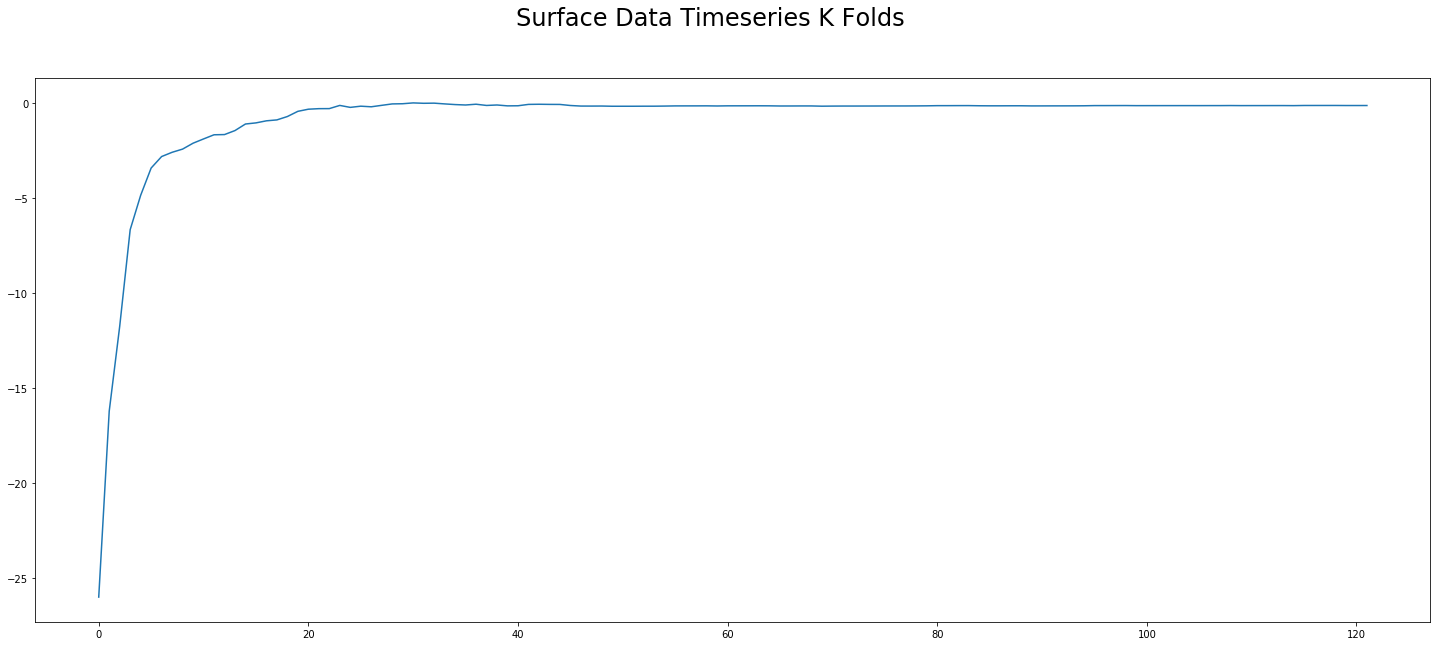

In [161]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
lm = linear_model.LinearRegression()

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error
from sklearn import metrics


tscv = KFold(n_splits=5)
print(tscv)  
print(len(X_feat_UASFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_UASFC))
slopes_UASFC, intercepts_UASFC, r_values_UASFC, p_values_UASFC, std_errs_UASFC,  rmse_UASFC = [],[],[],[],[], [] 
R2_scores_UASFC, meanR2_UASFC =[], []
rmse_UASFC, mean_rmse_UASFC =[], []


X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Surface Data Timeseries K Folds', fontsize=24)
count = 0
print(len(good_vars_UASFC))
for var_count in np.arange(1, len(good_vars_UASFC),1):
 R2_scores_UASFC = []
 rmse_UASFC = []
 for train_index, test_index in tscv.split(X_feat_UASFC):
  #print("TRAIN:", train_index, "TEST:", test_index)
   X_train =  np.array(tuple(x[0:var_count] for x in X_feat_UASFC))[train_index]
   X_test =  np.array(tuple(x[0:var_count] for x in X_feat_UASFC))[test_index]
   Y_train =  np.array(Y_actsnf)[train_index]
   Y_test =   np.array(Y_actsnf)[test_index]
 
   model = lm.fit(X_train, Y_train)
   Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 5)
   R2_scores_UASFC.append(metrics.r2_score(Ytest_predictions, Y_test))
   mse = mean_squared_error(Ytest_predictions, Y_test)
   rmse_UASFC.append(np.sqrt(mse)) 
 print(np.mean(R2_scores_UASFC), good_vars_UASFC[0:var_count])
 meanR2_UASFC.append(np.mean(R2_scores_UASFC) )
 mean_rmse_UASFC.append(np.mean(rmse_UASFC))

plt.plot(meanR2_UASFC)
print(np.max(meanR2_UASFC))
#plt.ylim([0,10])
# ax = fig.add_subplot(3,4,count+1)
# ax.scatter(Ytest_predictions, Y_test)
# ax.set_xlabel('PRedicted SNF', fontsize = 10)
# ax.set_ylabel('Actual SNF', fontsize = 10)

# ax.grid(True)
# count = count +1

In [ ]:
tscv = KFold(n_splits=10)
print(tscv)  
print(len(X_feat_UASFC))
print(len(Y_actsnf))

******
CMtn_Dewpoint_degC
0.03654017251076158
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.06027291248168454
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.05773365424084853
CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.055171146367332335
LXV_WindDirection_deg+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.052528849794918675
CMtn_Temperature_degC+ LXV_WindDirection_deg+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04789265753051741
LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.05004764652356597
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_WindDirection_deg+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.047841212012953216
LXV_Pressure_hp+ LXV_Dewpo

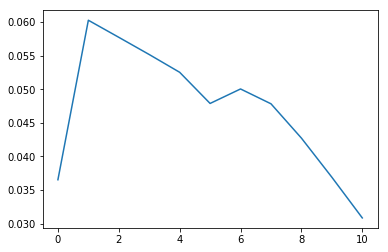

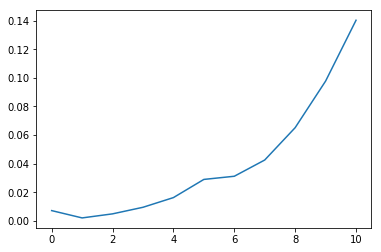

CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
TRAINING SUMMARY
TEST SUMMARY
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.078
Model:                                               OLS   Adj. R-squared:                  0.050
Method:                                    Least Squares   F-statistic:                     2.761
Date:                                   Sat, 16 Mar 2019   Prob (F-statistic):             0.0201
Time:                                           22:47:33   Log-Likelihood:                -371.99
No. Observations:                                    170   AIC:                             756.0
Df Residuals:                                        164   BIC:                             774.8
Df Model:                                              5                    

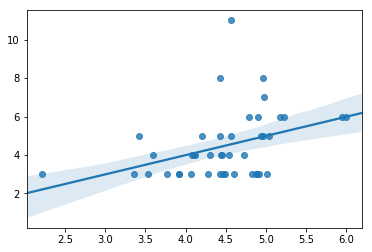

CMtn_Dewpoint_degC
0.04714358651494188
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.07727111812388021
CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08637612476320089
LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09646142077700304
CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.0955650163724917
LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09202593083795818
CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08686261916591387
LXV_WindSpeed_mps+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08141737988470221
LXV_Pressure_hp+ LXV_WindSpeed_mps+ CMtnSNTL_Temp_degC+ LXV

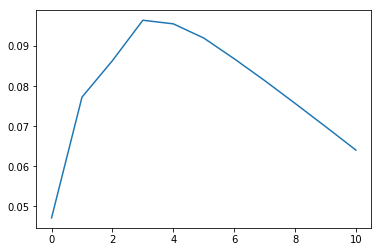

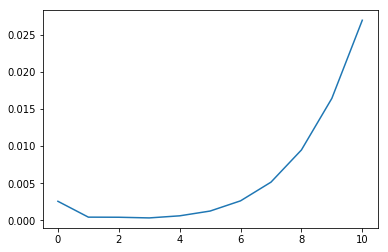

CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
TRAINING SUMMARY
TEST SUMMARY
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.111
Model:                                               OLS   Adj. R-squared:                  0.083
Method:                                    Least Squares   F-statistic:                     4.079
Date:                                   Sat, 16 Mar 2019   Prob (F-statistic):            0.00162
Time:                                           22:47:35   Log-Likelihood:                -370.29
No. Observations:                                    170   AIC:                             752.6
Df Residuals:                                        164   BIC:                             771.4
Df Model:                                              5                    

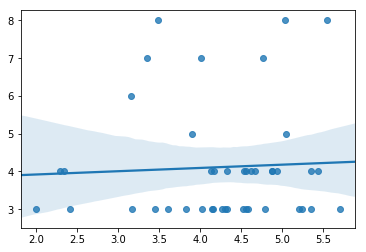

CMtn_Dewpoint_degC
0.06229549993794903
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08796040817176365
LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.0882610992090831
LXV_Temperature_degC+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08721395505414731
CMtn_Temperature_degC+ LXV_Temperature_degC+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09253209128631068
LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ LXV_Temperature_degC+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08963048072351232
CMtnSNTL_Temp_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ LXV_Temperature_degC+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08509522517606805
LXV_WindSpeed_mps+ CMtnSNTL_Temp_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_Temperature_degC+ LXV_Temperature_degC+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08095129291006298
CMtn_WindDirection_deg+ LXV_WindSpeed_mps+ CMtnSNTL_Temp_degC+ LXV_12hr_delta_Pressure_hp+

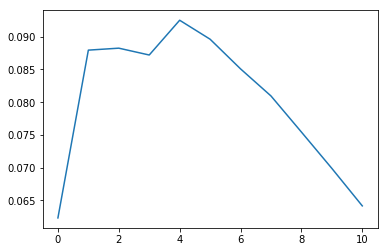

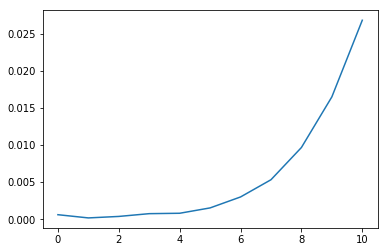

CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
TRAINING SUMMARY
TEST SUMMARY
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.108
Model:                                               OLS   Adj. R-squared:                  0.081
Method:                                    Least Squares   F-statistic:                     3.987
Date:                                   Sat, 16 Mar 2019   Prob (F-statistic):            0.00194
Time:                                           22:47:37   Log-Likelihood:                -362.47
No. Observations:                                    170   AIC:                             736.9
Df Residuals:                                        164   BIC:                             755.7
Df Model:                                              5                    

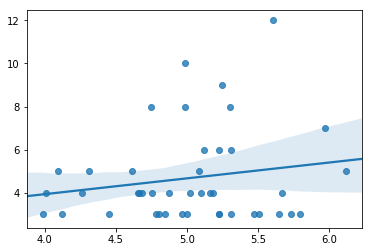

CMtn_Dewpoint_degC
0.05907542287628942
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.07074443838372735
CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.0778903384076064
LXV_Temperature_degC+ CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08516906958964054
LXV_WindDirection_deg+ LXV_Temperature_degC+ CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09143625687674317
LXV_Pressure_hp+ LXV_WindDirection_deg+ LXV_Temperature_degC+ CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09421631648625794
CMtn_Temperature_degC+ LXV_Pressure_hp+ LXV_WindDirection_deg+ LXV_Temperature_degC+ CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.09074276767006284
LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Pressure_hp+ LXV_WindDirection_deg+ LXV_Temperature_degC+ CMtn_WindDirection_deg+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.08735436138121966
LXV_Dewpoint_degC+ LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Pressure_hp+ LXV_WindD

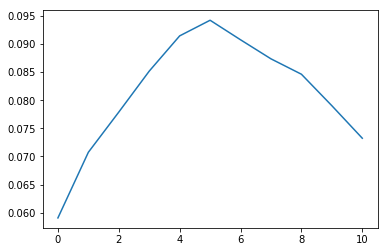

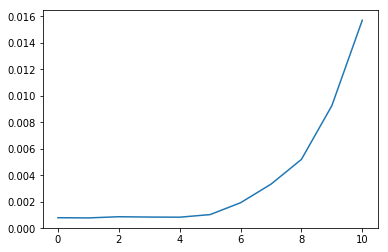

CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
TRAINING SUMMARY
TEST SUMMARY
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.097
Model:                                               OLS   Adj. R-squared:                  0.069
Method:                                    Least Squares   F-statistic:                     3.532
Date:                                   Sat, 16 Mar 2019   Prob (F-statistic):            0.00464
Time:                                           22:47:40   Log-Likelihood:                -352.54
No. Observations:                                    171   AIC:                             717.1
Df Residuals:                                        165   BIC:                             735.9
Df Model:                                              5                    

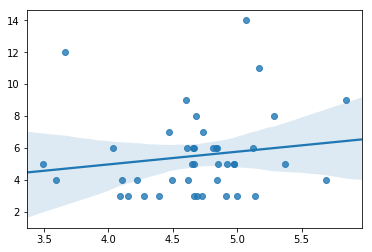

CMtn_Dewpoint_degC
0.026224114344317373
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.03762325513021836
LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04434365703081089
LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04554657000808626
CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04988977388954807
LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04939609224587849
LXV_Temperature_degC+ LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.04605989921207254
LXV_Pressure_hp+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
0.041487990899625626
LXV_WindDirection_deg+ LXV_Pressure_hp+ LXV_Temperature_degC+ LXV_WindSpeed_mp

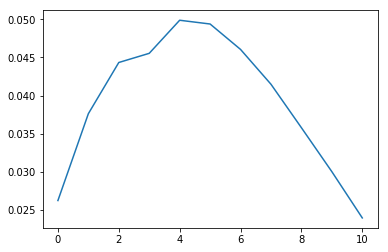

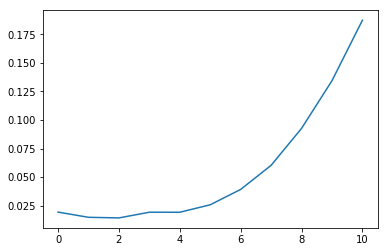

CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
TRAINING SUMMARY
TEST SUMMARY
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.078
Model:                                               OLS   Adj. R-squared:                  0.050
Method:                                    Least Squares   F-statistic:                     2.785
Date:                                   Sat, 16 Mar 2019   Prob (F-statistic):             0.0192
Time:                                           22:47:42   Log-Likelihood:                -360.61
No. Observations:                                    171   AIC:                             733.2
Df Residuals:                                        165   BIC:                             752.1
Df Model:                                              5                    

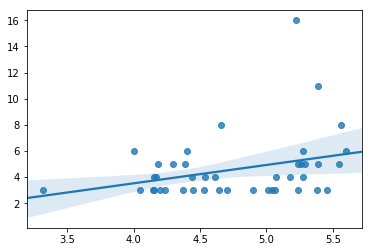

[0.026224114344317373, 0.03762325513021836, 0.04434365703081089, 0.04554657000808626, 0.04988977388954807, 0.04939609224587849, 0.04605989921207254, 0.041487990899625626, 0.035783515398634, 0.030014961766918313, 0.023943078979955068]
['CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'LXV_Temperature_degC+ LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC', 'LXV_Pressure_hp+ LXV_Temperature_degC+ LXV_WindSpeed_mps+ CMtn_WindDirection_deg+ LXV_12hr_delta_Pressure_hp+ LXV_Dewpoint_degC+ CMtn_WindSpeed_mps+ CM

In [201]:
import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols
from collections import OrderedDict



print('******')


all_Ytest_predictions_SFC, all_Ytests_SFC = [], []
all_Ytest_predictions_arrays_SFC, all_Ytests_arrays_SFC = [],[]

count = 0
for train_index, test_index in tscv.split(X_feat_SFC):
  #print("TRAIN:", train_index, "TEST:", test_index)
   X_train =  np.array(X_feat_SFC)[train_index]
   X_test =  np.array(X_feat_SFC)[test_index]
   Y_train =  np.array(Y_actsnf)[train_index]
   Y_test =   np.array(Y_actsnf)[test_index]
   
    
   Y_train_df = pd.DataFrame(X_train)
   Y_train_df.columns = good_vars_SFC
   Y_train_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = Y_train
   
   Y_test_df = pd.DataFrame(X_test)
   Y_test_df.columns = good_vars_SFC
   Y_test_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = Y_test
   
   variables = good_vars_SFC
   variables_org = variables
   adjRs, newRs, dup_var, max_vars, f_pvalues = [], [], [], [], []

   while variables != []:
    for var in variables:
      max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, Y_train_df).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
      OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, Y_train_df).fit()
      print(max_var)
      print(OLS.rsquared_adj)
    
      adjRs.append(OLS.rsquared_adj)
      f_pvalues.append(OLS.f_pvalue)
      max_vars.append(max_var)

      add_max_var = '+ '+ max_var
    
      variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
      for v in variables_org: 
        dup_var = []
        dup_var = [var for var in variables if var.count(v)>1]
        if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)
   plt.plot(adjRs)
   plt.show()
   plt.plot(f_pvalues)
   plt.show()
   maximum_all_str = max(dictionary, key=dictionary.get) 
   print(maximum_all_str)

   maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , Y_train_df).fit() 
   print('TRAINING SUMMARY')
   print('TEST SUMMARY')
   print(maxOLS_all.summary())
   predict_snf = maxOLS_all.predict(Y_test_df)
   all_Ytest_predictions_arrays_SFC.append(predict_snf)   #creates list of arrays
   all_Ytests_arrays_SFC.append(Y_test)   #creates list of arrays
   

   sns.regplot(predict_snf.values, Y_test)
   plt.show()
    

all_Ytest_predictions_SFC = [val for sublist in  all_Ytest_predictions_arrays_SFC for val in sublist]   #flattens list of arrays into single list of values
all_Ytests_SFC = [val for sublist in   all_Ytests_arrays_SFC for val in sublist]   #flattens list of arrays into single list of values


#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)
    


Text(0.5,1,'All KFolds - Predicted vs Actual Snowfall Amounts')

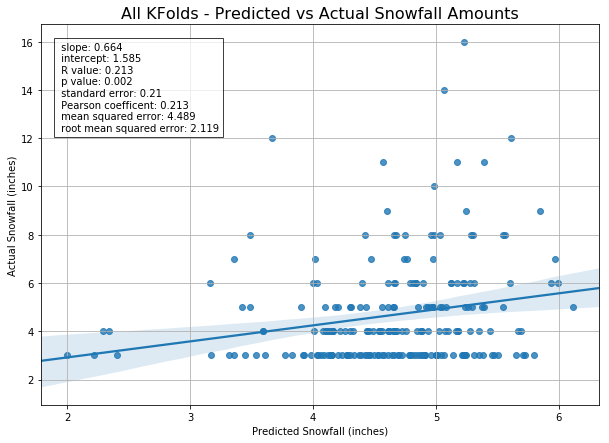

In [202]:
fig = plt.figure(figsize=(10,7))
## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(all_Ytest_predictions_SFC,all_Ytests_SFC)
#Calculate mse and rmse
mse = mean_squared_error(all_Ytest_predictions_SFC,all_Ytests_SFC)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(all_Ytest_predictions_SFC,all_Ytests_SFC)

#plot and annotate
sns.regplot(all_Ytest_predictions_SFC,all_Ytests_SFC)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([2,8])
#plt.ylim([0,16])
plt.grid(True)
plt.title('All KFolds - Predicted vs Actual Snowfall Amounts', fontsize = 16)

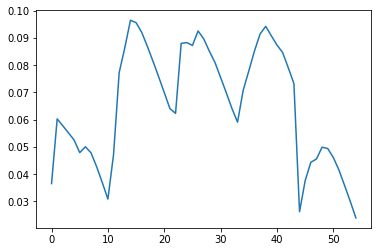

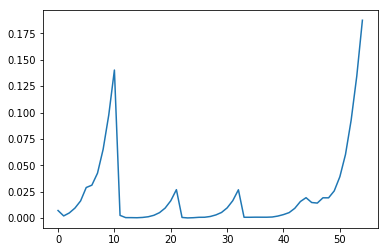

In [191]:
plt.plot(adjRs)
plt.show()
plt.plot(f_pvalues)
plt.show()

In [ ]:
print(len(X_feat_SFC))
print(len(good_vars_SFC))

table = [[1 , 2], [3, 4]]
df = pd.DataFrame(X_feat_SFC)

#df = df.transpose()
df.columns = good_vars_SFC
df['snf'] = Y_actsnf

print(df.describe())

In [135]:
print(good_vars_UASFC)
#print(X_feat_UASFC[1])
#print(X_feat_UASFC[1:3])
t = tuple(x[0:3] for x in X_feat_UASFC)
print(t)
for count_var in good_vars_SFC.index:
 print(good_vars_SFC[count_var])

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

TypeError: 'builtin_function_or_method' object is not iterable

# Surface K Fold

KFold(n_splits=10, random_state=None, shuffle=False)
213
213
<generator object _BaseKFold.split at 0x0F794360>
TRAIN: [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
22
TRAIN: [  0   1   2   3   4  

21


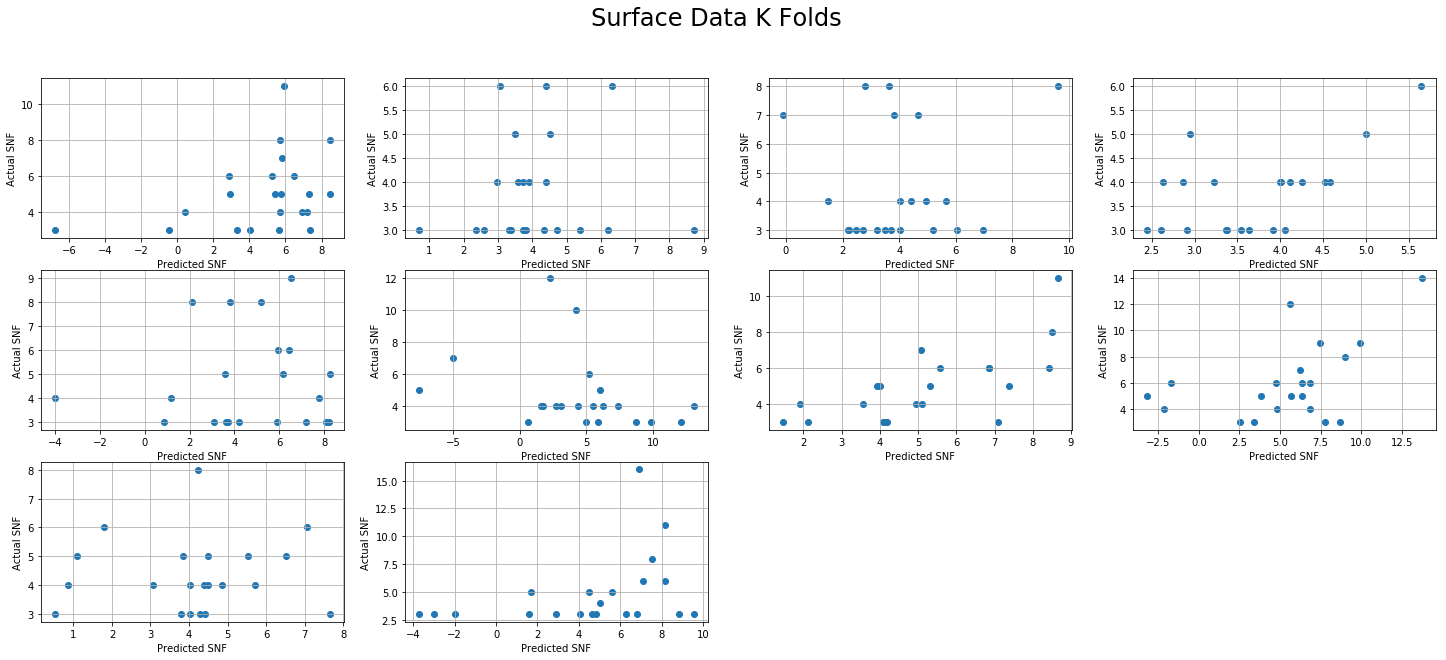

In [57]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


tscv = KFold(n_splits=10)
print(tscv)  
print(len(X_feat_SFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_SFC))

slopes_SFC, intercepts_SFC, r_values_SFC, p_values_SFC, std_errs_SFC,  rmse_SFC = [],[],[],[],[], [] 
R2_scores_SFC =[]
all_Ytest_predictions_SFC, all_Ytests_SFC = [], []
all_Ytest_predictions_arrays_SFC, all_Ytests_arrays_SFC = [],[]
X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Surface Data K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_SFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_SFC)[train_index]
 X_test =  np.array(X_feat_SFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 21)
 print(len(Y_test))
 R2_scores_SFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_SFC.append(slope)
 intercepts_SFC.append(intercept)
 r_values_SFC.append(r_value)
 p_values_SFC.append(p_value)
 std_errs_SFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_SFC.append(np.sqrt(mse))  
 all_Ytest_predictions_arrays_SFC.append(Ytest_predictions)   #creates list of arrays
 all_Ytests_arrays_SFC.append(Y_test)   #creates list of arrays

     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('Predicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)

 ax.grid(True)
 count = count +1
    
all_Ytest_predictions_SFC = [val for sublist in  all_Ytest_predictions_arrays_SFC for val in sublist]   #flattens list of arrays into single list of values
all_Ytests_SFC = [val for sublist in   all_Ytests_arrays_SFC for val in sublist]   #flattens list of arrays into single list of values

In [ ]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



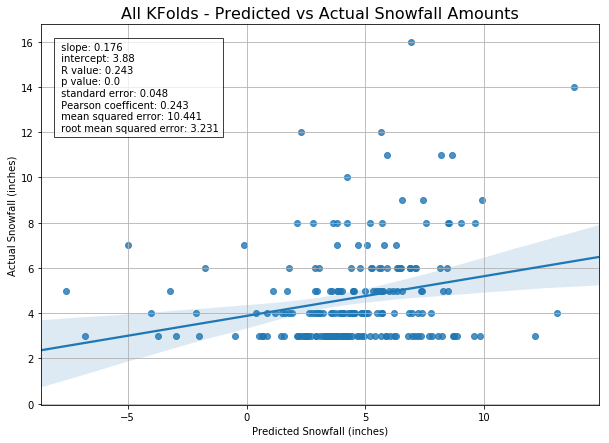

In [56]:
fig = plt.figure(figsize=(10,7))
## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(all_Ytest_predictions_SFC,all_Ytests_SFC)
#Calculate mse and rmse
mse = mean_squared_error(all_Ytest_predictions_SFC,all_Ytests_SFC)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(all_Ytest_predictions_SFC,all_Ytests_SFC)

#plot and annotate
sns.regplot(all_Ytest_predictions_SFC,all_Ytests_SFC)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([2,8])
#plt.ylim([0,16])
plt.grid(True)
plt.title('All KFolds - Predicted vs Actual Snowfall Amounts', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/KFOLDS_pred_vs_act_SFC.png',bbox_inches='tight')

Mean R2 Score=-0.19735841296612322
Mean p value =0.35501682946519464
MIn p value =0.0005986583689759092


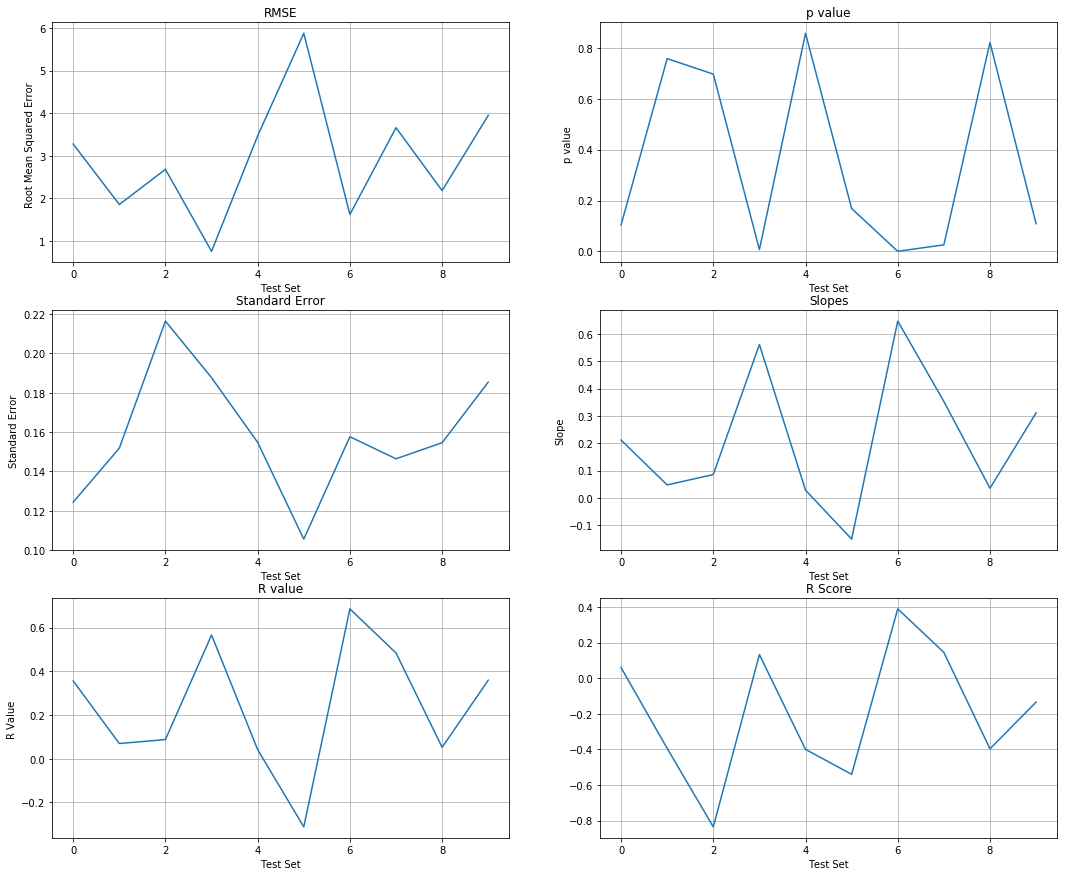

In [9]:
print("Mean R2 Score=" + str(np.mean(R2_scores_SFC)))
print("Mean p value =" +str(np.mean(p_values_SFC)))
print("MIn p value ="+str(np.min(p_values_SFC)))


fig = plt.figure(figsize=(18,15))  
#fig.suptitle('Surface Data K Folds', fontsize=24)

ax = fig.add_subplot(321)
ax.plot(rmse_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Root Mean Squared Error ', fontsize = 10)
ax.set_title('RMSE')
ax.grid(True)


ax = fig.add_subplot(322)
ax.plot(p_values_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('p value ', fontsize = 10)
ax.set_title('p value')
ax.grid(True)



ax = fig.add_subplot(323)
ax.plot(std_errs_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Standard Error', fontsize = 10)
ax.set_title('Standard Error')
ax.grid(True)


ax = fig.add_subplot(324)
ax.plot(slopes_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Slope', fontsize = 10)
ax.set_title('Slopes')
ax.grid(True)

ax = fig.add_subplot(325)
ax.plot(r_values_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('R Value ', fontsize = 10)
ax.set_title('R value')
ax.grid(True)

ax = fig.add_subplot(326)
ax.plot(R2_scores_SFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_title('R Score')
ax.grid(True)



plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/SFC_KFolds_stats.png',bbox_inches='tight')
plt.show()

In [10]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

#scores = cross_val_score(model, X_feat, Y_actsnf, cv=TimeSeriesSplit(n_splits=5).split(X_feat))
scores = cross_val_score(model, X_feat_SFC, Y_actsnf, cv=tscv.split(X_feat_SFC))
print(scores)
print(np.mean(scores))




[-0.05262772 -0.47630434  0.00411415 -2.89829764 -0.18381369  0.08433939
 -0.05581645 -0.32898167 -0.07255458  0.100147  ]
-0.38797955485772323


# Surface+Upper Air KFold

KFold(n_splits=10, random_state=None, shuffle=False)
213
213
<generator object _BaseKFold.split at 0x1216CC90>
TRAIN: [ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
22
TRAIN: [  0   1   2   3   4  

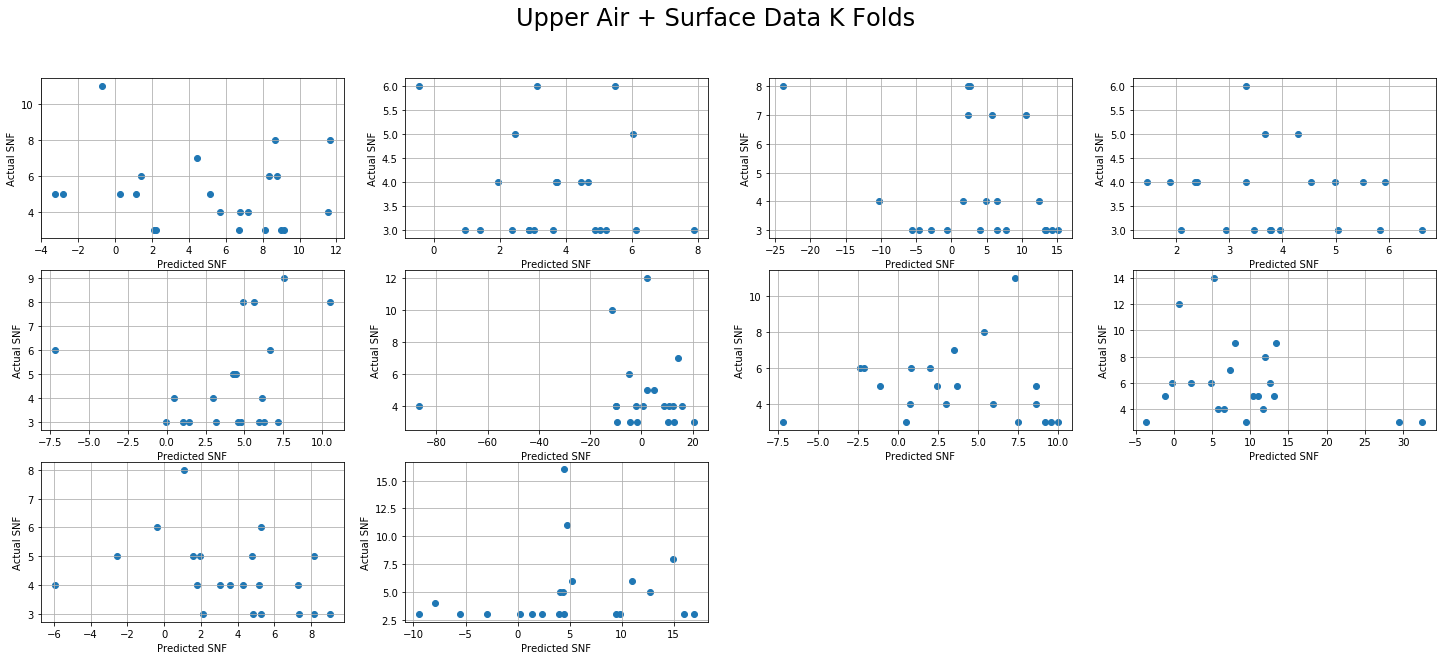

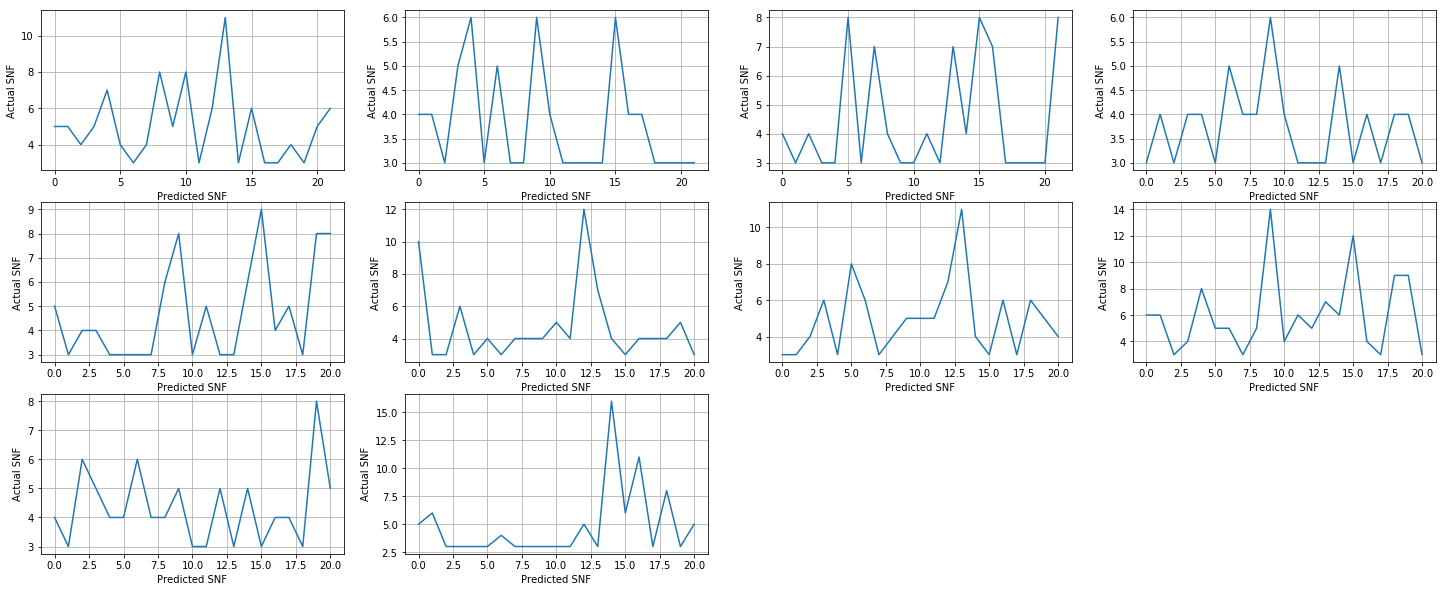

In [62]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


tscv = KFold(n_splits=10)
print(tscv)  
print(len(X_feat_UASFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_UASFC))

slopes_UASFC, intercepts_UASFC, r_values_UASFC, p_values_UASFC, std_errs_UASFC,  rmse_UASFC = [],[],[],[],[], [] 
R2_scores_UASFC =[]
all_Ytest_predictions_UASFC, all_Ytests_UASFC = [], []
all_Ytest_predictions_arrays_UASFC, all_Ytests_arrays_UASFC = [],[]
X_train = np.array([])
Ytest_predictions, Y_test = [], []
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig2 = plt.figure(figsize=(25,10))
fig.suptitle('Upper Air + Surface Data K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_UASFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_UASFC)[train_index]
 X_test =  np.array(X_feat_UASFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 21)
 print(len(Y_test))
 R2_scores_UASFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_UASFC.append(slope)
 intercepts_UASFC.append(intercept)
 r_values_UASFC.append(r_value)
 p_values_UASFC.append(p_value)
 std_errs_UASFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_UASFC.append(np.sqrt(mse))  
 all_Ytest_predictions_arrays_UASFC.append(Ytest_predictions)   #creates list of arrays
 all_Ytests_arrays_UASFC.append(Y_test)   #creates list of arrays

     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('Predicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)
 ax.grid(True)

 ax2 = fig2.add_subplot(3,4,count)
 ax2.plot(Y_test)
 ax2.set_xlabel('Predicted SNF', fontsize = 10)
 ax2.set_ylabel('Actual SNF', fontsize = 10)
 ax2.grid(True)

 count = count +1
    
all_Ytest_predictions_UASFC = [val for sublist in  all_Ytest_predictions_arrays_UASFC for val in sublist]   #flattens list of arrays into single list of values
all_Ytests_UASFC = [val for sublist in   all_Ytests_arrays_UASFC for val in sublist]   #flattens list of arrays into single list of values



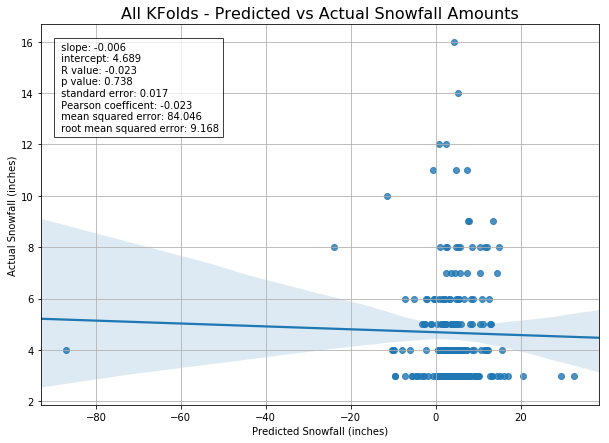

In [35]:
fig = plt.figure(figsize=(10,7))
## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(all_Ytest_predictions_UASFC,all_Ytests_UASFC)
#Calculate mse and rmse
mse = mean_squared_error(all_Ytest_predictions_UASFC,all_Ytests_UASFC)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(all_Ytest_predictions_UASFC,all_Ytests_UASFC)

#plot and annotate
sns.regplot(all_Ytest_predictions_UASFC,all_Ytests_UASFC)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([2,8])
#plt.ylim([0,16])
plt.grid(True)
plt.title('All KFolds - Predicted vs Actual Snowfall Amounts', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/KFOLDS_pred_vs_act_UASFC.png',bbox_inches='tight')


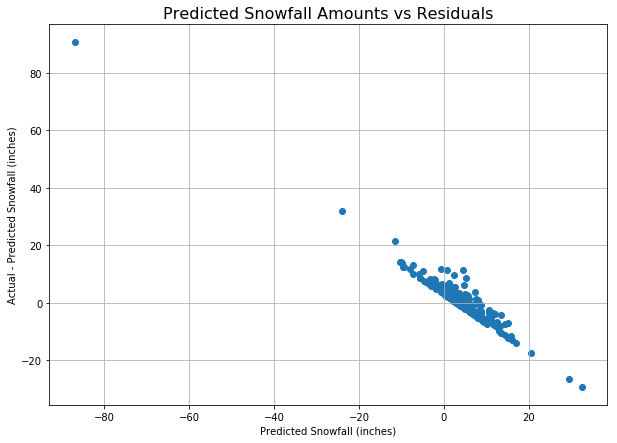

In [41]:
fig = plt.figure(figsize=(10,7))

plt.scatter(np.array(all_Ytest_predictions_UASFC), np.array(all_Ytests_UASFC)-np.array(all_Ytest_predictions_UASFC))
#print(predict[idx].values)
#print(actual_snf[idx].values)
#print(actual_snf[idx].values-predict[idx].values)

plt.ylabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Predicted Snowfall (inches)')
#plt.xlim([2,7])
#plt.ylim([-3,13])
plt.grid(True)
plt.title('Predicted Snowfall Amounts vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/KFolds_resid_vs_pred_UASFC.png',bbox_inches='tight')

TypeError: 'line' is an invalid keyword argument for this function

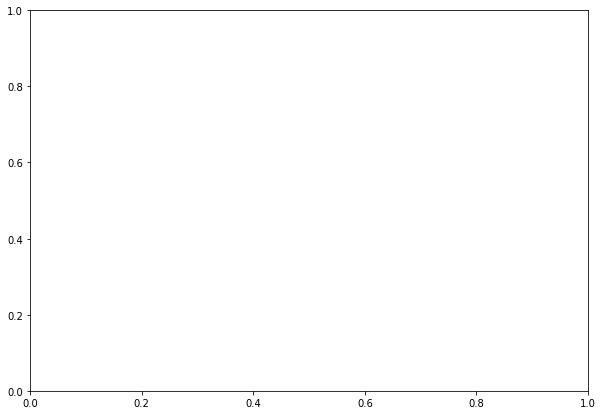

In [44]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot(np.array(all_Ytests_UASFC)-np.array(all_Ytest_predictions_UASFC, line='r', ax = ax))
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)
plt.ylim([-5,13])
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/KFold_qq_resid_UASFC.png',bbox_inches='tight')

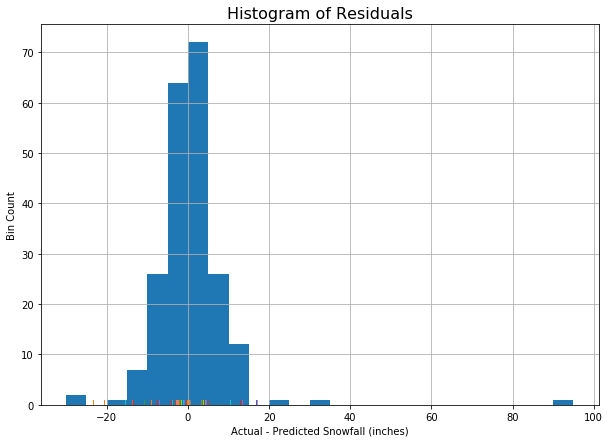

In [49]:

diff = np.array(all_Ytests_UASFC)-np.array(all_Ytest_predictions_UASFC)
diff_df = pd.DataFrame(diff)

#fig = plt.figure(figsize=(10,7))
hist = diff_df.hist(figsize=(10,7), bins = np.arange(-30,100,5))
plt.hist(diff_df)
plt.xlabel('Actual - Predicted Snowfall (inches)')
plt.ylabel('Bin Count')
#plt.xlim([-4,14])
#plt.ylim([0,10])
#plt.grid(True)
plt.title('Histogram of Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/KFold_hist_actual_minus_pred_UASFC.png',bbox_inches='tight')

Mean R2 Score=-0.293773343009584
Mean p value =0.4604706335783332
MIn p value =0.10994923923393274


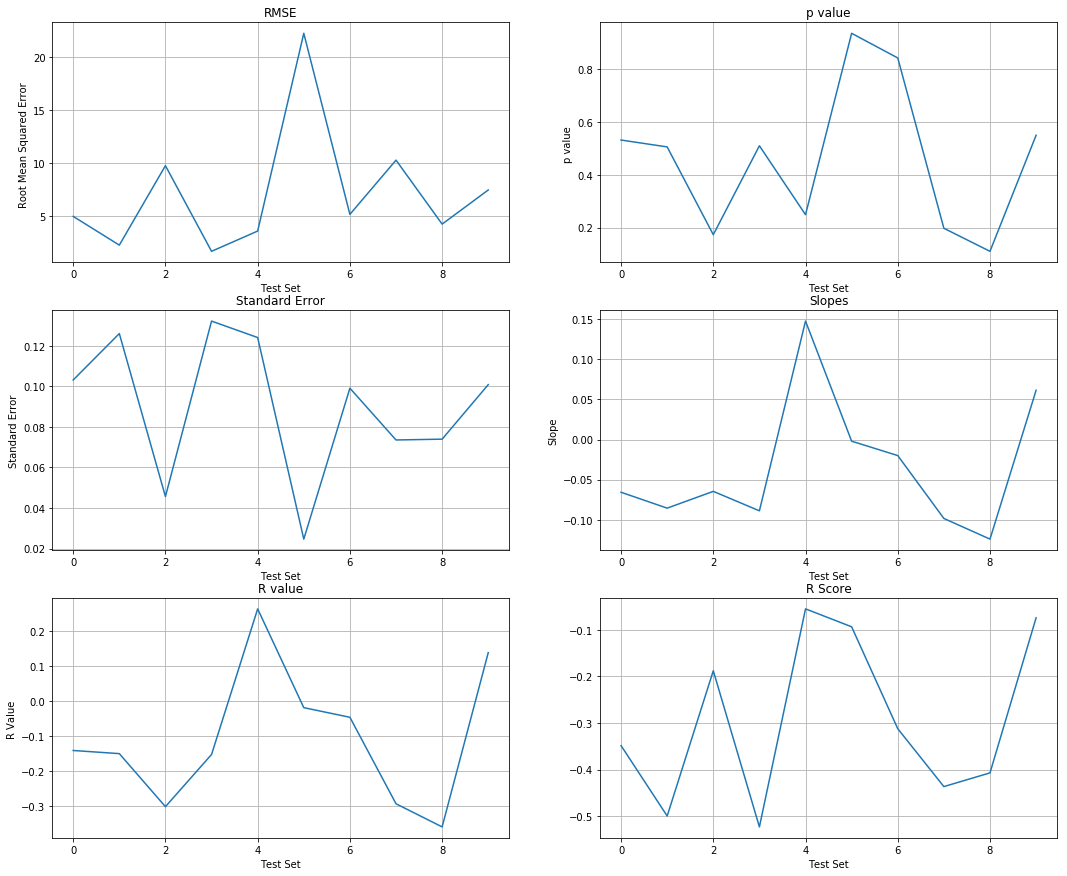

In [50]:
print("Mean R2 Score=" + str(np.mean(R2_scores_UASFC)))
print("Mean p value =" +str(np.mean(p_values_UASFC)))
print("MIn p value ="+str(np.min(p_values_UASFC)))


fig = plt.figure(figsize=(18,15))  
#fig.suptitle('Surface Data K Folds', fontsize=24)

ax = fig.add_subplot(321)
ax.plot(rmse_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Root Mean Squared Error ', fontsize = 10)
ax.set_title('RMSE')
ax.grid(True)


ax = fig.add_subplot(322)
ax.plot(p_values_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('p value ', fontsize = 10)
ax.set_title('p value')
ax.grid(True)



ax = fig.add_subplot(323)
ax.plot(std_errs_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Standard Error', fontsize = 10)
ax.set_title('Standard Error')
ax.grid(True)


ax = fig.add_subplot(324)
ax.plot(slopes_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('Slope', fontsize = 10)
ax.set_title('Slopes')
ax.grid(True)

ax = fig.add_subplot(325)
ax.plot(r_values_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_ylabel('R Value ', fontsize = 10)
ax.set_title('R value')
ax.grid(True)

ax = fig.add_subplot(326)
ax.plot(R2_scores_UASFC)
ax.set_xlabel('Test Set', fontsize = 10)
ax.set_title('R Score')
ax.grid(True)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/UASFC_KFolds_stats.png',bbox_inches='tight')
plt.show()




TimeSeriesSplit(max_train_size=None, n_splits=5)
213
213
<generator object TimeSeriesSplit.split at 0x1334F180>
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37] TEST: [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72]
35
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72] TEST: [ 73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
35
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  

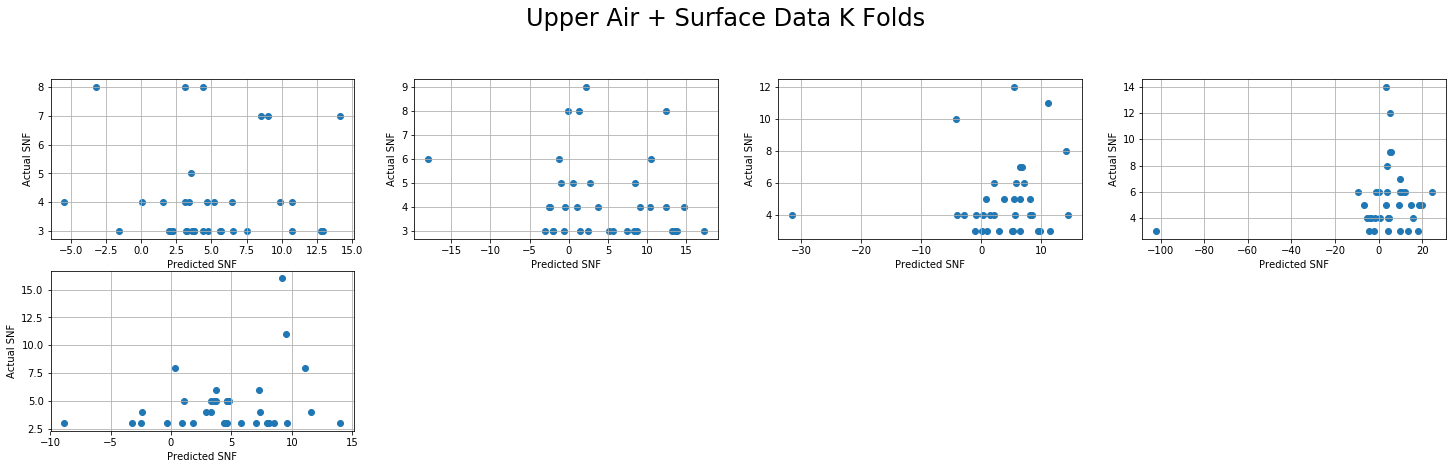

In [54]:
from sklearn.model_selection import TimeSeriesSplit # import KFold
from sklearn.model_selection import KFold # import KFold

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  
print(len(X_feat_UASFC))
print(len(Y_actsnf))

print(tscv.split(X_feat_UASFC))

slopes_UASFC, intercepts_UASFC, r_values_UASFC, p_values_UASFC, std_errs_UASFC,  rmse_UASFC = [],[],[],[],[], [] 
R2_scores_UASFC =[]
all_Ytest_predictions_UASFC, all_Ytests_UASFC = [], []
all_Ytest_predictions_arrays_UASFC, all_Ytests_arrays_UASFC = [],[]
X_train = np.array([])
 
    
#Surface Only
fig = plt.figure(figsize=(25,10))
fig.suptitle('Upper Air + Surface Data K Folds', fontsize=24)
count = 1
for train_index, test_index in tscv.split(X_feat_UASFC):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat_UASFC)[train_index]
 X_test =  np.array(X_feat_UASFC)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 23)
 print(len(Y_test))
 R2_scores_UASFC.append(metrics.r2_score(Ytest_predictions, Y_test))
 slope, intercept, r_value, p_value, std_err = linregress(Ytest_predictions, Y_test)    
 slopes_UASFC.append(slope)
 intercepts_UASFC.append(intercept)
 r_values_UASFC.append(r_value)
 p_values_UASFC.append(p_value)
 std_errs_UASFC.append(std_err)
 mse = mean_squared_error(Ytest_predictions, Y_test)
 rmse_UASFC.append(np.sqrt(mse))  
 all_Ytest_predictions_arrays_UASFC.append(Ytest_predictions)   #creates list of arrays
 all_Ytests_arrays_UASFC.append(Y_test)   #creates list of arrays

     
 ax = fig.add_subplot(3,4,count)
 ax.scatter(Ytest_predictions, Y_test)
 ax.set_xlabel('Predicted SNF', fontsize = 10)
 ax.set_ylabel('Actual SNF', fontsize = 10)

 ax.grid(True)
 count = count +1
    
all_Ytest_predictions_UASFC = [val for sublist in  all_Ytest_predictions_arrays_UASFC for val in sublist]   #flattens list of arrays into single list of values
all_Ytests_UASFC = [val for sublist in   all_Ytests_arrays_UASFC for val in sublist]   #flattens list of arrays into single list of values

